In [1]:
import os
import random

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from numpy import linalg as la

from ipywidgets import IntProgress
from IPython.display import display

sns.set()

# Utilities

In [2]:
def img_show(img, title = '', figsize=(20,10)):
    plt.figure(figsize=figsize)
    sns.set_style("white")
    plt.imshow(img)
    plt.gray()
    plt.title(title)
    plt.show()
    
def imgs_show(imgs, rows, fontsize=36):
    fig = plt.figure()
    sns.set_style("white")
    for n, (img, title) in enumerate(imgs):
        a = fig.add_subplot(rows, np.ceil(len(imgs)/float(rows)), n + 1)
        a.set_title(title, fontdict={"fontsize": fontsize})
        plt.gray()
        plt.imshow(img)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(imgs))
    plt.show()
    
def read_folder(folder, ext):
    images = []

    for r, d, f in os.walk(folder):
        for file in f:
            if file.endswith(ext):
                path = os.path.join(r, file)
                images.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

    return images

# Download datasets

In [3]:
%%bash

FACES_LINK="http://mlsp.cs.cmu.edu/courses/fall2013/assignments/assignment2/lfw1000.zip"
FACES_FILE_NAME="lfw1000.zip"

NON_FACES_FILE_NAME="non_face.zip"

download() {
    if [ -f "$2" ]; then
        echo "$2 exist"
    else 
        curl "$1" --output "$2"
    fi
}

download $FACES_LINK $FACES_FILE_NAME

unzip $FACES_FILE_NAME
unzip att_faces.zip -d att_faces
unzip $NON_FACES_FILE_NAME

Couldn't find program: 'bash'


# Read datasets LFW1000 and Linnaeus 5 64X64

In [4]:
images = np.array(read_folder('./lfw1000/', '.pgm'))
non_face_images = np.array(read_folder('./non_face/', '.jpg'))

print("Faces dataset: {}. Non-faces dataset: {}".format(images.shape, non_face_images.shape))

train, test = train_test_split(images, test_size=.2, random_state=512, shuffle=True)
print("Train set shape: {}. Test set shape: {}".format(train.shape, test.shape))

_, non_face_test = train_test_split(non_face_images, test_size=.1, random_state=512)
print("Non face test set shape: {}".format(non_face_test.shape))

Faces dataset: (1071, 64, 64). Non-faces dataset: (2000, 64, 64)
Train set shape: (856, 64, 64). Test set shape: (215, 64, 64)
Non face test set shape: (200, 64, 64)


# Data exploration of FW1000 and Linnaeus 5 64X64 datasets

Lets check sample from the dataset with faces and see the mean face. And also check non faces data.

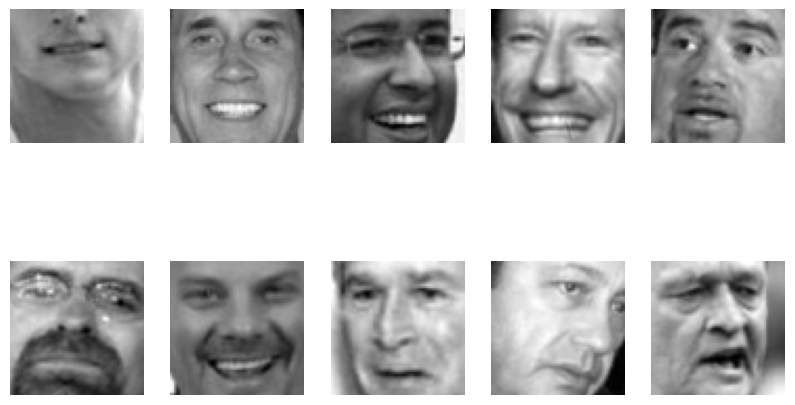

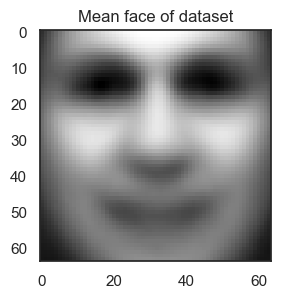

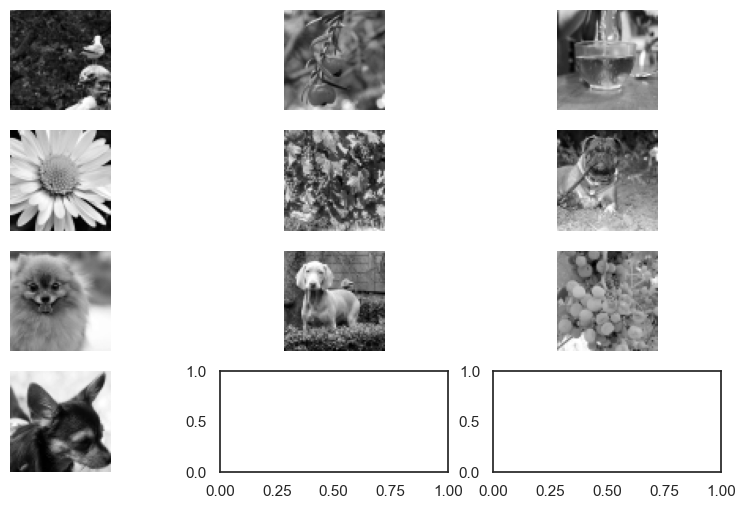

In [5]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ... (rest of your code)

random.seed(512)

# Sample 10 faces
sample_faces = [(images[i], "") for i in random.sample(range(0, len(images)), 10)]

# Display faces in a 2x5 grid (adjust rows and cols as needed)
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
for n, (img, title) in enumerate(sample_faces):
    ax = axes.flat[n]
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')  # Optional: Hide axes for cleaner presentation

# Display mean face
img_show(np.mean(images, axis=(0)), title="Mean face of dataset", figsize=(4, 3))

# Sample 10 non-faces
sample_non_faces = [(non_face_images[i], "") for i in random.sample(range(0, len(non_face_images)), 10)]

# Display non-faces in a 4x3 grid (adjust rows and cols as needed)
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
for n, (img, title) in enumerate(sample_non_faces):
    ax = axes.flat[n]
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')  # Optional: Hide axes

plt.show()  # Display all plots


In [6]:
# random.seed(512)

# sample = [(images[i], "") for i in random.sample(range(0, len(images)), 10)]
# imgs_show(sample, 1)
# img_show(np.mean(images, axis=(0)), title="Mean face of dataset", figsize=(4,3))

# imgs_show([(non_face_images[i], "") for i in random.sample(range(0, len(non_face_images)), 10)], 1)

# PCA classifier implementation

In [7]:
class Classifier:
    def __init__(self):
        self.data = None
        self.mean = 0
        self.normalized = None
        self.cov = None
        
        self.desc_ordered_vals_indexes = None
        self.eigenvals = None
        self.eigenvecs = None
        self.eigenfaces = None
        
        self.number_of_components = 0
        self.weights = None
        
        self.threshold = 0
        
    def fit(self, X):
        self.data = X
        self.mean = np.mean(X, axis=0)
        self.normalized = np.array([(x - self.mean).flatten() for x in self.data])
        self.cov = self.normalized.dot(self.normalized.T)/self.normalized.shape[0]
        
        vals, vecs = la.eig(self.cov)
        self.desc_ordered_vals_indexes = np.flip(np.argsort(vals))
        
        self.eigenvals = np.array([vals[i] for i in self.desc_ordered_vals_indexes])
        self.eigenvecs = np.array([vecs[i] for i in self.desc_ordered_vals_indexes])
        
        eigenfaces = self.normalized[self.desc_ordered_vals_indexes].T.dot(self.eigenvecs)
        self.eigenfaces = eigenfaces/la.norm(eigenfaces, axis=0)
    
    def calculate_weights(self, number_of_components):
        eigenfaces_to_use = self.eigenfaces[:,:number_of_components]
        
        self.weights = np.dot(self.normalized, eigenfaces_to_use)
        self.number_of_components = number_of_components
        
    def calculate_threshold(self):
        distances = np.array([])
        for i in range(self.number_of_components):
            for j in range(i, self.number_of_components):
                distances = np.append(distances, np.sqrt(la.norm(self.weights[i] - self.weights[j])))
                
        self.threshold = np.max(distances) / 2
        return self.threshold
    
    def reduce_dimention(self, Y, number_of_components):
        y_normalized = (Y - self.mean).flatten()[..., np.newaxis]
        eigenfaces_to_use = self.eigenfaces[:, :number_of_components]
        return eigenfaces_to_use.dot(eigenfaces_to_use.T).dot(y_normalized) + self.mean.flatten()[..., np.newaxis]
    
    def __find_weights(self, Y):
        y_normalized = (Y - self.mean).flatten()[..., np.newaxis]
        eigenfaces_to_use = self.eigenfaces[:,:self.number_of_components]
        return np.dot(eigenfaces_to_use.T, y_normalized)
    
    def find_closest(self, Y):
        w_unknown = self.__find_weights(Y)
        eps_k = np.sqrt(la.norm(np.subtract(self.weights, w_unknown.T), axis=1))
        min_eps_k = round(np.min(eps_k), 1)
        epsilon = round(self.calculate_epsilon(Y), 1)
        closest_img = self.data[np.argmin(eps_k)]
        
        threshold = round(self.threshold, 1)
#         print("Threshold:{}, Epsilon:{}, Epsilon_k:{}".format(threshold, epsilon, min_eps_k))
        
        if epsilon >= threshold:
            return closest_img, None
        elif epsilon < self.threshold and min_eps_k >= threshold:
            return closest_img, False
        return closest_img, True
        
    
    def calculate_epsilon(self, Y):
        w_unknown = self.__find_weights(Y)
        eigenfaces_to_use = self.eigenfaces[:,:self.number_of_components]
        reconstructed = eigenfaces_to_use.dot(w_unknown).reshape(Y.shape) + self.mean
        epsilon = np.sqrt(la.norm(Y.reshape(-1) - reconstructed.reshape(-1)))
        return epsilon
        
    def predict(self, Y):
        epsilon = self.calculate_epsilon(Y)
        return epsilon < self.threshold

# Add plots to PCA classifier

In [8]:
class PlotableClassifier(Classifier):
    def __init__(super):
        pass
    
    def plot_importance(self, n=10):
        first_n_eigenvalues = self.eigenvals[:n]
        importance = first_n_eigenvalues/np.sum(self.eigenvals)
        
        
        fig, ax = plt.subplots(figsize=(10, 8))
        df = pd.DataFrame({
            'Percentage of variances': importance, 
            'Principal components number': [i+1 for i in range(n)],
        })
        
        sns.set_style("whitegrid")
        sns.barplot(
            ax=ax,
            x='Principal components number', 
            y='Percentage of variances', 
            data=df,
            palette=sns.cubehelix_palette(8),
        ).set_title(
            'Amount of variances convered by {} principal components is {}%'.format(
                n, 
                round(df['Percentage of variances'].sum()*100, 3),
            ),
        )
        plt.show()
        
        return df
    
    def plot_dependence(self, thresholds=(0.95, 0.99)):
        sum_of_eigenvals = np.sum(self.eigenvals)
        first_threshold_reached = 0
        second_threshold_reached = 0
        dependence = [sum(self.eigenvals[:n+1])/sum_of_eigenvals for n in range(len(self.eigenvals))]
        for i, n in enumerate(dependence):
            if n > thresholds[0] and first_threshold_reached == 0:
                first_threshold_reached = i
            elif n > thresholds[1] and second_threshold_reached == 0:
                second_threshold_reached = i
                break
        
        df = pd.DataFrame({
            'Sum of variances': dependence, 
            'Principal components number': [i+1 for i in range(len(self.eigenvals))],
        })
        fig, ax = plt.subplots(figsize=(10, 8))
        
        sns.lineplot(
            ax=ax,
            x='Principal components number', 
            y='Sum of variances', 
            data=df,
            palette=sns.color_palette("Blues_d", len(self.eigenvals)),
        ).set_title('Sum of variances. Thresholds={}. Number of components respectively={}'.format(
            thresholds, (first_threshold_reached, second_threshold_reached)
        ))
        
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        plt.axhline(y=thresholds[0], color='green')
        plt.axhline(y=thresholds[1], color='r')
        plt.axvline(first_threshold_reached, color='green')
        plt.axvline(second_threshold_reached, color='r')
        plt.show()
        
        return df
    
    def find_best_threshold(self, faces, non_faces, n=11):
        f = IntProgress(min=0, max=n, description='Computing:', bar_style='info')
        display(f)
        
        components = list(range(1,n+1))
        face_errors = np.array([])
        not_face_errors = np.array([])
        thresholds = np.array([])
 
        for k in components:
            pca.calculate_weights(k)
            thresholds = np.append(thresholds, pca.calculate_threshold())
            face_errors = np.append(face_errors, np.mean([pca.calculate_epsilon(face) for face in faces]))
            not_face_errors = np.append(not_face_errors, np.mean([pca.calculate_epsilon(image) for image in non_faces]))

            f.value += 1
            
        err_avg = np.array([(face_errors[i] + not_face_errors[i]) / 2 for i in range(n)])
        best = np.argmin(np.abs(err_avg - thresholds))
            
        df = pd.DataFrame({
            'Components': components,
            'Thresholds': thresholds,
            'Faces errors': face_errors, 
            'Non faces errors': not_face_errors,
            'Error avg': err_avg
        })
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        sns.set_style("whitegrid")
        sns.lineplot(
            ax=ax, 
            x='Components', 
            y='value', 
            hue='variable', 
            data=pd.melt(df, ['Components']),
        ).set_title('Best number of components is: {}'.format(best+1))
        sns.regplot(x=np.array([best+1]), y=np.array([err_avg[best]]), scatter=True, fit_reg=False, marker='o', scatter_kws={"s": 100})
        return best+1
    
    # def plot_eigenfaces_sample(self, n=10):
    #     random_eigenfaces_indexes = random.sample(range(0, self.eigenfaces.shape[1]), n)
    #     sample = [(self.eigenfaces.T[i].reshape(self.data[0].shape), "") for i in random_eigenfaces_indexes]
    #     imgs_show(sample, 1)

    def plot_eigenfaces_sample(self, n=10):
        """Displays a grid of randomly selected eigenfaces."""
        rows, cols = 2, int(np.ceil(n / 2))  # Adjust rows and cols as needed
        fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
        random_eigenfaces_indexes = random.sample(range(0, self.eigenfaces.shape[1]), n)

        for n, i in enumerate(random_eigenfaces_indexes):
            ax = axes.flat[n]
            ax.imshow(self.eigenfaces.T[i].reshape(self.data[0].shape), cmap='gray')
            ax.set_title(f"Eigenface {i+1}")
            ax.axis('off')  # Optional: Hide axes

        plt.tight_layout()  # Adjust spacing between subplots (optional)
        plt.show()

# Training the classifier on dataset

In [9]:
pca = PlotableClassifier()
pca.fit(train)

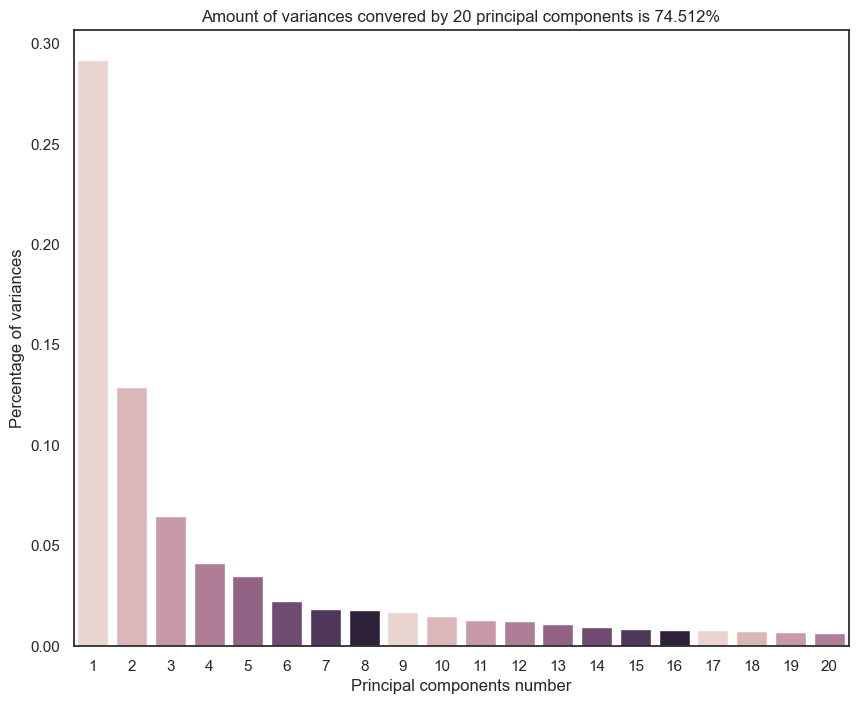

,Percentage of variances,Principal components number
0,0.291932,1
1,0.129016,2
2,0.064667,3
3,0.041618,4
4,0.035147,5


In [10]:
pca.plot_importance(n=20).head()

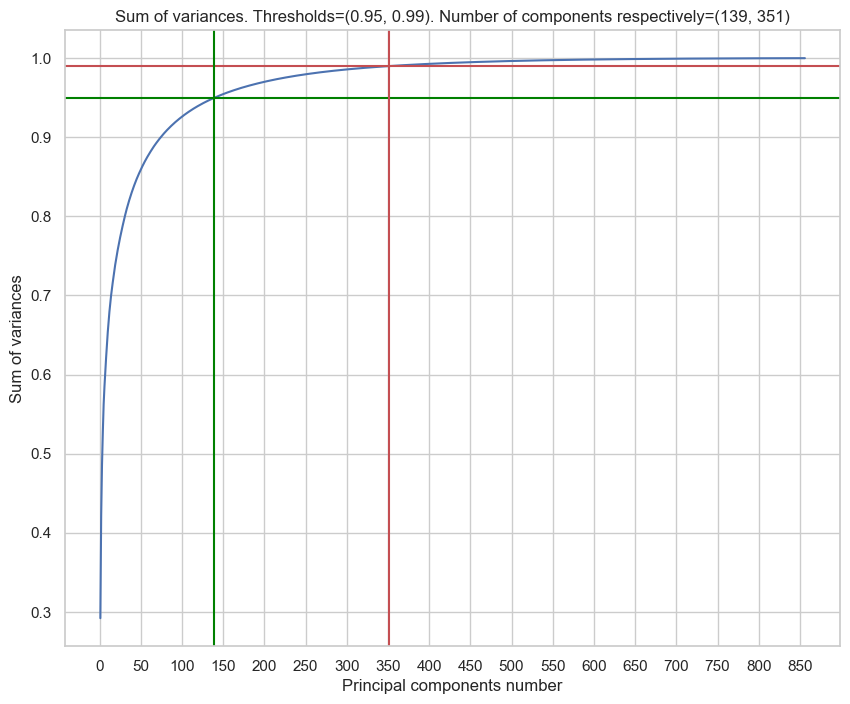

,Sum of variances,Principal components number
0,0.291932,1
1,0.420948,2
2,0.485615,3
3,0.527233,4
4,0.562380,5


In [11]:
pca.plot_dependence().head()

IntProgress(value=0, bar_style='info', description='Computing:', max=51)

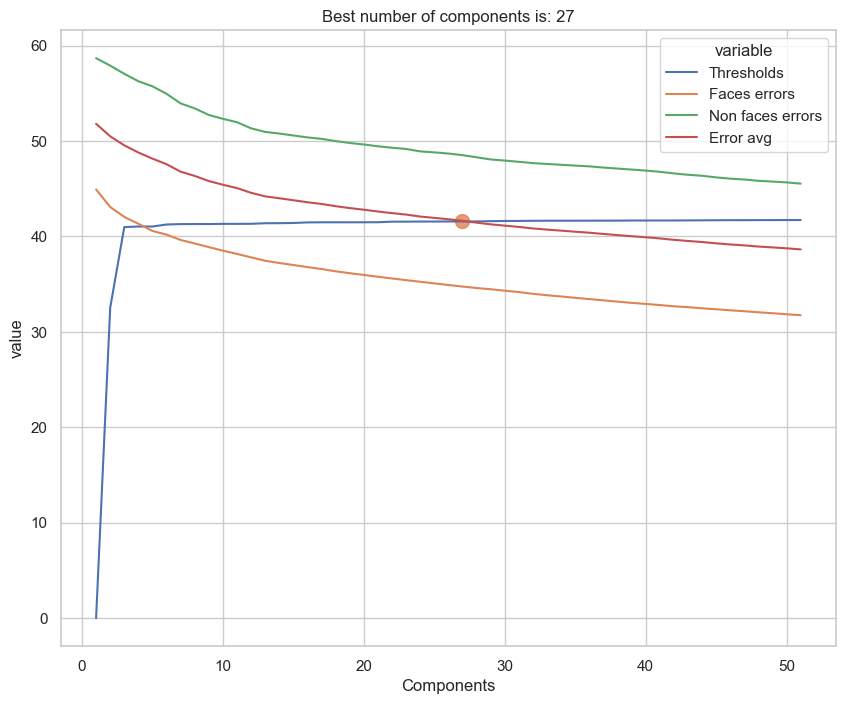

In [12]:
best_number_of_components = pca.find_best_threshold(test, non_face_test, n=51)

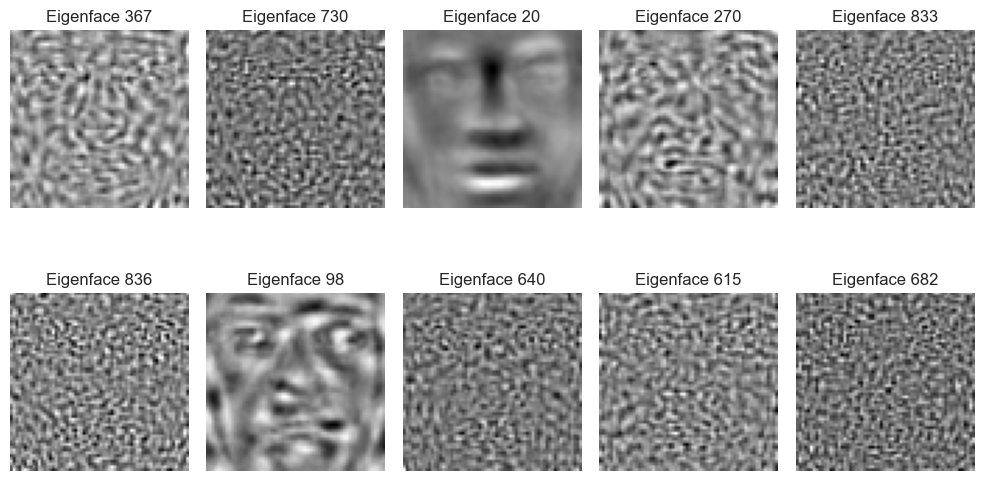

In [13]:
pca.plot_eigenfaces_sample()

# Reduce dimentionality of the image

One can notice that alogirthm performs well on faces in comparision with other type of objects.

In [14]:
def dimentionality_reduction_plot(test_image, pca, prinicipal_components_number):
  """Plots the original image and its reduced dimensionality versions."""
  img_show(test_image, "Original", figsize=(3, 4))

  format_img_title = lambda i, img: "PC number={},\nmse={}".format(
      prinicipal_components_number[i],
      round(np.square(test_image - img).mean(), 2),
  )

  reduced_dimentionality_images = [
      pca.reduce_dimention(test_image, i).reshape(test_image.shape)
      for i in prinicipal_components_number
  ]
  images_to_plot = [
      (img, format_img_title(i, img)) for i, img in enumerate(reduced_dimentionality_images)
  ]

  # Create subplots and adjust spacing automatically
  fig, axes = plt.subplots(len(images_to_plot))
  for n, (img, title) in enumerate(images_to_plot):
    ax = axes[n]
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=8)
    ax.axis('off')

  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
  plt.show()

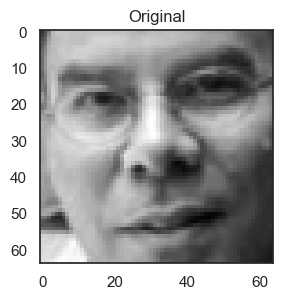

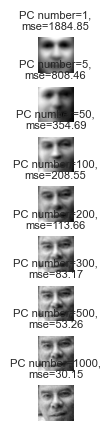

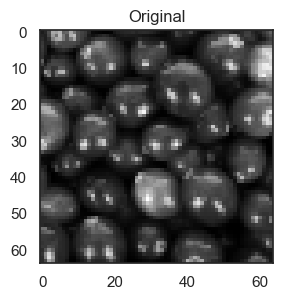

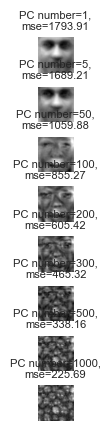

In [15]:
# def dimentionality_reduction_plot(test_image, pca, prinicipal_components_number):
#     img_show(test_image, "Original", figsize=(3,4))

#     format_img_title = lambda i, img: "PC number={},\nmse={}".format(
#         prinicipal_components_number[i], 
#         round(np.square(test_image - img).mean(), 2),
#     )

#     reduced_dimentionality_images = [pca.reduce_dimention(test_image, i).reshape(test_image.shape) for i in prinicipal_components_number]
#     images_to_plot = [(img, format_img_title(i, img)) for i, img in enumerate(reduced_dimentionality_images)]

#     imgs_show(images_to_plot, 1, 30)
    
dimentionality_reduction_plot(test[0], pca, [1, 5, 50, 100, 200, 300, 500, 1000])
dimentionality_reduction_plot(non_face_images[0], pca, [1, 5, 50, 100, 200, 300, 500, 1000])

# Lets check how our solution will recognize the images in test datasets

Firstly we need to select number of prinicipal components for reconstraction, then calculate wights and project test data on the prinicipal components space.

In [16]:
pca.calculate_weights(best_number_of_components)
pca.calculate_threshold()

41.5784011269028

These faces hasn't been seen buy the alogorithm.

In [26]:

# random.seed(512)

# # # Assuming 8 images and a 2x4 grid layout
# # images_to_show = [(test[i], "Face = {}".format(pca.predict(test[i]))) for i in random.sample(range(0, len(test)), 8)]
# # imgs_show(images_to_show, 2, 4)  # Explicitly define rows and columns

# import math

# # Assuming 8 images and a 2x4 grid layout
# images_to_show = [(test[i], "Face = {}".format(pca.predict(test[i]))) for i in random.sample(range(0, len(test)), 8)]

# # Calculate number of rows and columns
# num_images = len(images_to_show)
# num_rows = 2

# if num_images <= num_rows:
#     num_cols = 1
# else:
#     num_cols = math.ceil(num_images / num_rows)

# print("Number of images:", num_images)
# print("Number of rows:", num_rows)
# print("Number of columns:", num_cols)

# imgs_show(images_to_show, num_rows, num_cols)  # Explicitly define rows and columns

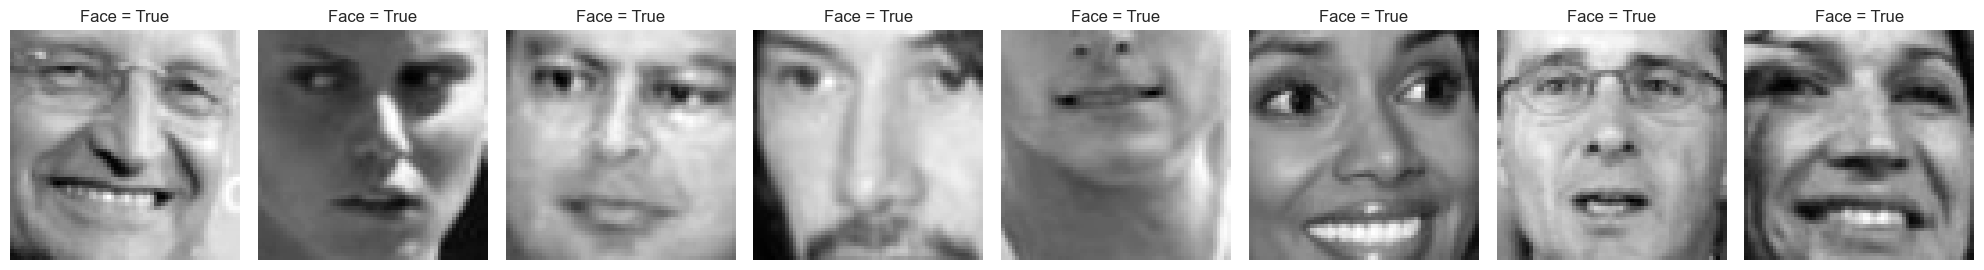

In [28]:
random.seed(512)

images_to_show = [(test[i], "Face = {}".format(pca.predict(test[i]))) for i in random.sample(range(0, len(test)), 8)]

# Create subplots in a single row (8 images)
fig, ax = plt.subplots(1, 8, figsize=(20, 4))  # Adjust figsize for better visibility

for n, (img, title) in enumerate(images_to_show):
    ax[n].imshow(img, cmap='gray')  # Assuming grayscale images
    ax[n].set_title(title)
    ax[n].axis('off')  # Optional: Hide axes

plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()

In [29]:
#random.seed(512)
#imgs_show([(test[i], "Face = {}".format(pca.predict(test[i]))) for i in random.sample(range(0, len(test)), 8)], 1, 40)

These images are not faces at all. Some of the images 

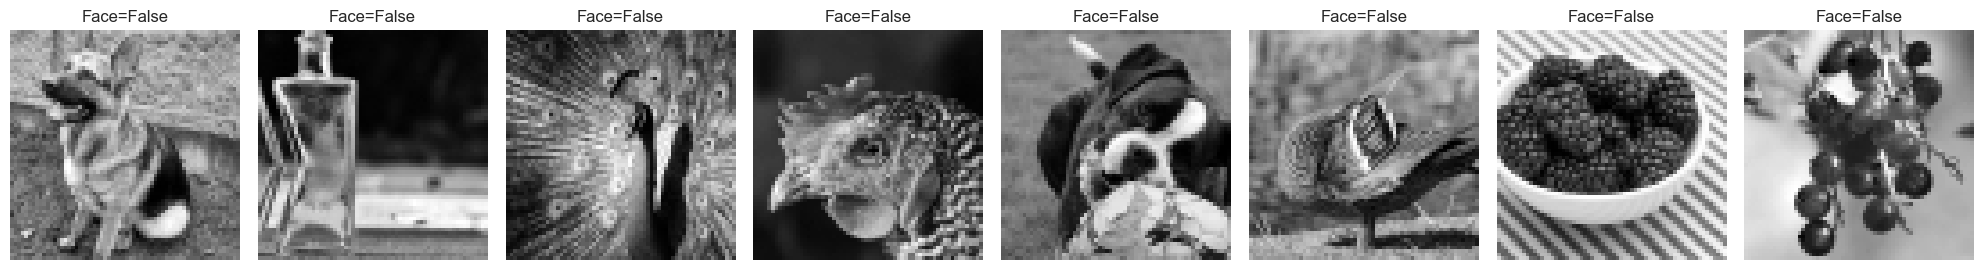

In [31]:
random.seed(256)

images_to_show = [(non_face_test[i], "Face={}".format(pca.predict(non_face_test[i]))) for i in random.sample(range(0, len(non_face_test)), 8)]

# Create a single row with 8 subplots
fig, ax = plt.subplots(1, 8, figsize=(20, 4))  # Adjust figsize if needed

for n, (img, title) in enumerate(images_to_show):
    ax[n].imshow(img, cmap='gray')  # Assuming grayscale images
    ax[n].set_title(title)
    ax[n].axis('off')  # Optional: Hide axes

plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()

Accuracy=0.9156626506024096
Precision=0.9128440366972477
Recall=0.9255813953488372
F1 Score=0.9191685912240185


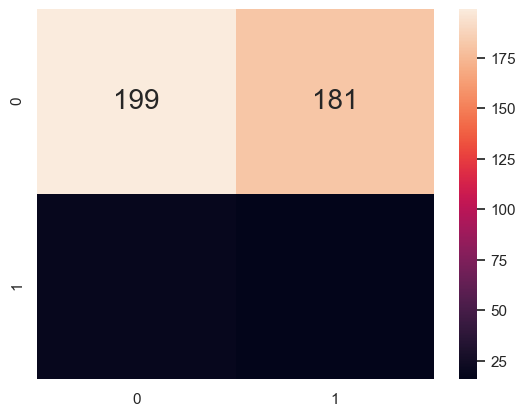

In [32]:
y_true = [len(test), len(non_face_test)]
y_pred = [
    sum([pca.predict(img) for img in test]),
    len(non_face_test) - sum([pca.predict(img) for img in non_face_test])
]

tp = y_pred[0]
tn = y_pred[1]
fp = y_true[1] - y_pred[1]
fn = y_true[0] - y_pred[0]
df_cm = pd.DataFrame([[tp, tn], [fp, fn]] , range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 20})
precision=tp/(tp+fp)
recall=tp/(tp+fn)
print("Accuracy={}".format((tp + tn)/(tp+tn+fp+fn)))
print("Precision={}".format(precision))
print("Recall={}".format(recall))
print("F1 Score={}".format(2*(precision*recall/(precision+recall))))

# Face recognition

For this task another dataset called AT&T Laboratories Cambridge is used. This is done because the each class has the same number of images.

In [33]:
def find_best_number_of_components(train, test):
    f = IntProgress(min=0, max=len(train)//2, description='Computing:', bar_style='info')
    display(f)
    
    face_recognition_pca = Classifier()
    face_recognition_pca.fit(np.array(train))
    accuracy = []
    for n in range(len(train)//2):
        face_recognition_pca.calculate_weights(n+1)
        face_recognition_pca.calculate_threshold()
        count = 0
        for img in test:
            _, face_in_db = face_recognition_pca.find_closest(img)
            if face_in_db:
                count+=1
        f.value += 1
        accuracy.append(count/len(test))
        
    return accuracy

In [46]:
att_faces = np.array(read_folder('./att_faces/', '.pgm'))
accuracies = []
kf = KFold(n_splits=5, random_state=512, shuffle=True)
for train_index, test_index in kf.split(att_faces):
    accuracy = find_best_number_of_components(att_faces[train_index], att_faces[test_index])
    accuracies.append((max(accuracy), np.argmax(accuracy)))
    print(max(accuracy))

IntProgress(value=0, bar_style='info', description='Computing:', max=160)

0.7125


IntProgress(value=0, bar_style='info', description='Computing:', max=160)

0.8


IntProgress(value=0, bar_style='info', description='Computing:', max=160)

0.7625


IntProgress(value=0, bar_style='info', description='Computing:', max=160)

0.85


IntProgress(value=0, bar_style='info', description='Computing:', max=160)

0.85


In [50]:
number_of_components = []
accuracy = []

for t in accuracies:
    number_of_components.append(t[1] + 1)
    accuracy.append(t[0])
    
best = int(np.mean(number_of_components)) + 1
    
print("K-fold cross validation accuracy is: {}, best number of components: {}".format(
    round(np.mean(accuracy), 2),
    best,
))

K-fold cross validation accuracy is: 0.8, best number of components: 101


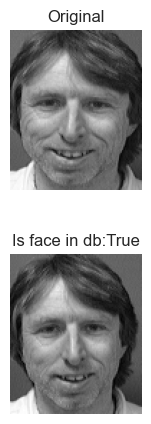

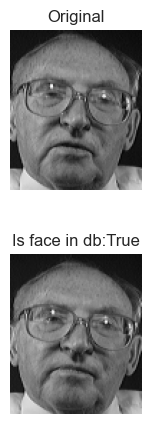

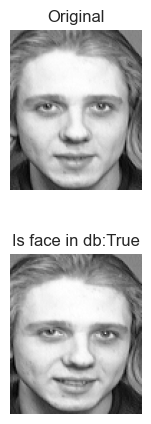

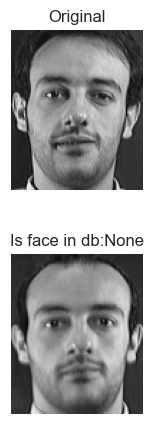

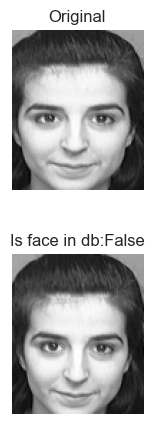

In [53]:
from sklearn.model_selection import train_test_split
att_faces_train, att_faces_test = train_test_split(att_faces, test_size=0.2, random_state=512, shuffle=True)

face_recognition_pca = PlotableClassifier()
face_recognition_pca.fit(att_faces_train)

face_recognition_pca.calculate_weights(best)
face_recognition_pca.calculate_threshold()

random.seed(256)
for i in random.sample(range(0, len(att_faces_test)), 5):
  original = att_faces_test[i]
  closest, face_in_db = face_recognition_pca.find_closest(att_faces_test[i])

  # Create subplots and adjust spacing automatically
  fig, axes = plt.subplots(2)  # Assuming 2 images (original and closest)
  axes[0].imshow(original, cmap='gray')
  axes[0].set_title("Original")
  axes[0].axis('off')
  axes[1].imshow(closest, cmap='gray')
  axes[1].set_title("Is face in db:{}".format(face_in_db))
  axes[1].axis('off')
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
  plt.show()

Face-Recognition-using-LDA

steps:
1.Read the images and convert into a vector of 10304 (92*112) values corresponding to the image size.
2.Split the data to training and testing with a percantage of 50 % for each batch
3.Apply the LDA algorithm steps with a final goal of computing the eigen-values and eigen-vectors
4.Apply the KNN algorithm with different K valuesfor the calssification phase, prediction the values of the test data batch and calculating the accuracy

Done images reading
-----------------------------------------------------------
Done Train Test Split
-----------------------------------------------------------
Done classes means computing
-----------------------------------------------------------
Done overall mean computing
-----------------------------------------------------------
Done between class scater matrix computing
-----------------------------------------------------------
Done center class scatter matrix computing
-----------------------------------------------------------
Done within class scatter matrix computing
-----------------------------------------------------------
Done W = S^(-1)B  computing
-----------------------------------------------------------
Done eigen values and vectors computing
-----------------------------------------------------------


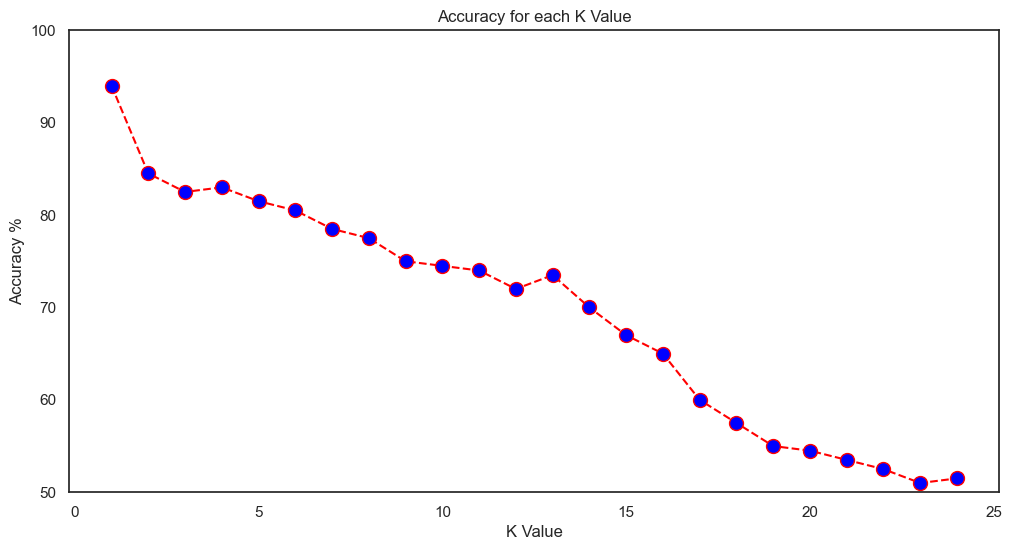

In [45]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsClassifier
import warnings
import re
warnings.simplefilter("ignore")

#************************************************************************************
# def read_images():
#     file_name = "att_faces"
#     data_directory = ""+file_name
    
#     data = np.zeros((400,10304))
#     labels = np.zeros((400,1)) 
    
#     i=0
#     for name in os.listdir(data_directory):
#         folderPath = os.path.join(data_directory,name)
#         for ImageName in os.listdir(folderPath):
#             Image_path = os.path.join(folderPath,ImageName)
            
#             img = cv2.imread(Image_path,0)
#             data[i,:] = img.flatten()
#             labels[i] =  int(name)
#             i+=1
#     return data,labels


def read_images():
    file_name = "att_faces"
    data_directory = "" + file_name
    
    data = np.zeros((400, 10304))
    labels = np.zeros((400, 1)) 
    
    i = 0
    for name in os.listdir(data_directory):
        folderPath = os.path.join(data_directory, name)
        # Extract the numeric part of the class label
        class_label = re.search(r'\d+', name).group(0)
        for ImageName in os.listdir(folderPath):
            Image_path = os.path.join(folderPath, ImageName)
            
            img = cv2.imread(Image_path, 0)
            data[i, :] = img.flatten()
            labels[i] = int(class_label)
            i += 1
    return data, labels
#************************************************************************************
    
def train_test_split(data,labels):
    train_split_value = int(data.shape[0]*(5/10))
    test_split_value = data.shape[0] - train_split_value
    
    train_data = np.zeros((train_split_value,10304))
    train_labels = np.zeros((train_split_value,1)) 
    
    test_data = np.zeros((test_split_value,10304))
    test_labels = np.zeros((test_split_value,1))
    
    #odd rows for train data, even rows for test data
    i_train=0
    i_test=0
    for i in range(data.shape[0]):
        #even
        if i%2==0:
           test_data[i_test,:] = data[i]
           test_labels[i_test] = labels[i]
           i_test+=1
        #odd
        else:
           train_data[i_train,:] = data[i]
           train_labels[i_train] = labels[i]
           i_train+=1
           
    return train_data,train_labels,test_data,test_labels

#************************************************************************************  
    
# compute the mean matrix for rach of the 40 classes
def compute_classes_mean_matrix(train_data,train_labels):
    means = np.zeros((40,10304)) 
    train_test_split_ratio = 5
    
    for i in range(1,41):
        temp = np.where(train_labels == i)[0]
        temp_sum = np.zeros((1,10304)) 
        for j in range (train_test_split_ratio):
           temp_sum += train_data[temp[j],:]        
            
        means[i-1,:] = temp_sum / train_test_split_ratio
    return means

#************************************************************************************
    
#the overall mean for all the 40 classes
#10304*1
def compute_overall_mean_matrix(classes_means):
    temp_sum = np.zeros((1,10304)) 
    for i in range(0,40):
        temp_sum +=classes_means[i,:]
    overall_mean = temp_sum / 40
    
    return overall_mean.T

#************************************************************************************
    
#the matrix of the overall scatter between all the 40 classes
def compute_between_class_scatter_matrix(classes_means,overall_mean):
    n=5
    #10304*10304
    Sb = np.zeros((classes_means.shape[1],classes_means.shape[1]))
    for i in range(classes_means.shape[0]):
        Sb = np.add(Sb,n* ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))
    return Sb

#************************************************************************************
    
def compute_center_class_matrix(train_data,train_labels,classes_means):
    Z = np.zeros(train_data.shape)
    
    for i in range(train_data.shape[0]):
        Z[i,:] = train_data[i,:] - classes_means[int(train_labels[i])-1,:]

    return Z

#************************************************************************************
    
def compute_class_scatter_matrix(Z):
    S = np.zeros((10304,10304))
    S = np.dot(Z.T,Z)
    return S  

#************************************************************************************
    
def data_dimencionality_reduction(train_data,test_data):
    train_data_dimensionally_reductuted = np.zeros((200,40)) 
    test_data_dimensionally_reductuted = np.zeros((200,40)) 
    
    i=0
    for img in train_data:
        train_data_dimensionally_reductuted[i,:]=np.dot(img,eigen_vectors)
        i+=1
    i=0
    for img in test_data:
        test_data_dimensionally_reductuted[i,:] = np.dot(img,eigen_vectors)
        i+=1
        
    return train_data_dimensionally_reductuted,test_data_dimensionally_reductuted

#************************************************************************************
    
def plot_accuracy_graph(accuracy):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 25), accuracy, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
    plt.ylim(50, 100)
    plt.title('Accuracy for each K Value')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy %')
    
#************************************************************************************
#************************************************************************************ 
    
if  __name__ == '__main__':
    
    data,labels = read_images()
    print('Done images reading')
    print('-----------------------------------------------------------')
    
    train_data,train_labels,test_data,test_labels = train_test_split(data,labels)
    
    print('Done Train Test Split')
    print('-----------------------------------------------------------')
    
    classes_means = compute_classes_mean_matrix(train_data,train_labels)
    print('Done classes means computing')
    print('-----------------------------------------------------------')
    
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('Done overall mean computing')
    print('-----------------------------------------------------------')
    
    S_between = compute_between_class_scatter_matrix(classes_means,overall_mean)
    print('Done between class scater matrix computing')
    print('-----------------------------------------------------------')
    
    Z = compute_center_class_matrix(train_data,train_labels,classes_means)
    print('Done center class scatter matrix computing')
    print('-----------------------------------------------------------')
    
    S_classes = compute_class_scatter_matrix(Z)
    print('Done within class scatter matrix computing')
    print('-----------------------------------------------------------')
    
    W_value = np.dot(np.linalg.inv(S_classes),S_between)
    print('Done W = S^(-1)B  computing')
    print('-----------------------------------------------------------')
    
    #40 largest eigen values
    eigen_values,eigen_vectors = scipy.linalg.eigh(W_value,eigvals=((10304-40),(10304-1)))
    print('Done eigen values and vectors computing')
    print('-----------------------------------------------------------')
    
    #reduce dimensionality of both train and test data sets
    train_data_dimensionally_reductuted,test_data_dimensionally_reductuted = data_dimencionality_reduction(train_data,test_data)
    
    
    accuracy = []
    #Apply KNN
    for i in range(1, 25):
        classifier = KNeighborsClassifier(n_neighbors=i)
        classifier.fit(train_data_dimensionally_reductuted, train_labels)
    
        test_predict = classifier.predict(test_data_dimensionally_reductuted)
        
        true_predicted_count=0
        for j in range(0,200):
            if test_predict[j] ==test_labels[j]:
                true_predicted_count+=1
        accuracy.append((true_predicted_count/200)*100)
    
    #plot graph for different K values
    plot_accuracy_graph(accuracy)

In [ ]:
Deeplearning

In [3]:
!pip install tensorflow

In [7]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not detected.")


GPU is not detected.


In [8]:
!pip install opencv-python

In [9]:
!pip install matplotlib

Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

Collect Positives and Anchors
Untar Labelled Faces in the Wild Dataset

In [4]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

2.2 Collect Positive and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\e3cea789-e817-11ee-9424-047c16e5bb51.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [12]:
cv2.waitkey??

Object `cv2.waitkey` not found.


In [10]:
print(frame)

[[[ 75  75  71]
  [ 76  77  72]
  [ 74  76  71]
  ...
  [103 103  99]
  [100 100  95]
  [102 101  96]]

 [[ 75  75  71]
  [ 76  77  72]
  [ 74  76  71]
  ...
  [101 102  98]
  [100 101  96]
  [100 101  96]]

 [[ 75  75  71]
  [ 76  77  72]
  [ 74  76  71]
  ...
  [100 101  96]
  [100 101  96]
  [100 101  96]]

 ...

 [[138 126 120]
  [138 126 120]
  [137 125 119]
  ...
  [126 147 173]
  [126 147 174]
  [126 147 175]]

 [[137 127 121]
  [137 127 121]
  [135 125 119]
  ...
  [125 146 172]
  [125 146 173]
  [125 146 173]]

 [[136 129 123]
  [138 130 124]
  [137 127 121]
  ...
  [124 145 171]
  [125 146 173]
  [125 146 173]]]


In [11]:
frame.shape

(250, 250, 3)

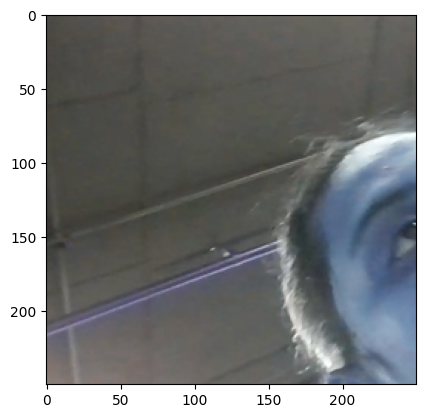

In [12]:
plt.imshow(frame[:250,:250, :])

NEW - Data Augmentation

In [13]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [14]:
import os
import uuid

In [16]:
img_path = os.path.join(ANC_PATH, '1a5f88d3-e819-11ee-bec3-047c16e5bb51.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [17]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

 Load and Preprocess Images
 Get Image Directories

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(200)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(200)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(200)

In [19]:
dir_test = anchor.as_numpy_iterator()

In [20]:
print(dir_test.next())

b'data\\anchor\\409fd2db-e748-11ee-8677-743af4ee1197.jpg'


 Preprocessing - Scale and Resize

In [21]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [22]:
img = preprocess('D:\\final\\data\\anchor\\1a5f88d3-e819-11ee-bec3-047c16e5bb51.jpg')

In [23]:
img.numpy().max()

1.0

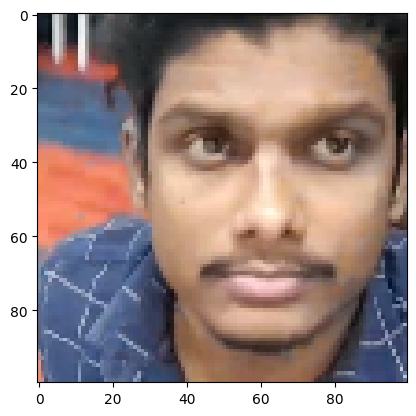

In [24]:
plt.imshow(img)

In [25]:
data.map(preprocess)

NameError: name 'data' is not defined

Create Labelled Dataset

In [26]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [27]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [28]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data\\anchor\\b79f5911-e752-11ee-96f6-743af4ee1197.jpg',
 b'data\\positive\\967f7f4d-e819-11ee-9a4b-047c16e5bb51.jpg',
 1.0)

Build Train and Test Partition

In [30]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

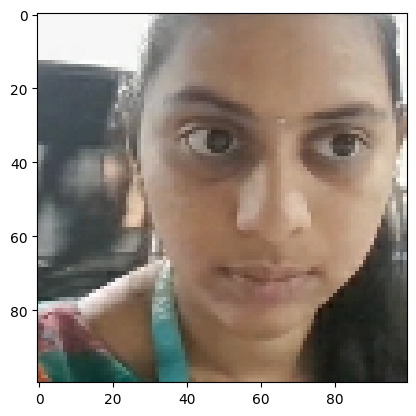

In [31]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [32]:
res[2]

1.0

In [33]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [34]:
round(len(data)*.7)

280

In [35]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [36]:
train_samples=train_data.as_numpy_iterator()
train_sample= train_samples.next()
len(train_sample[0])

16

In [37]:
round(len(data)*.3)

120

In [38]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [39]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [40]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

Model Engineering
Build Embedding Layer

In [41]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [42]:
6*6*256

9216

In [43]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [45]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [46]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

Build Distance Layer

In [47]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [48]:
l1 = L1Dist()


In [50]:
#l1(anchor_embedding, validation_embedding)

Make Siamese Model

In [53]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))


In [54]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [55]:
val_embedding


<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [56]:
embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [57]:
siamese_layer = L1Dist()

In [58]:
distances = siamese_layer(inp_embedding, val_embedding)
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [59]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [60]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [63]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

Training
Setup Loss and Optimizer

In [64]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

Establish Checkpoints

In [65]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Build Train Step Function

In [66]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [67]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

Build Training Loop

In [68]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Train the model

In [69]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
18/18 [==============================] - 122s 7s/step
0.44052982 0.7887324 0.8115942

 Epoch 2/50
18/18 [==============================] - 121s 7s/step
0.079152234 0.9066667 0.9066667

 Epoch 3/50
18/18 [==============================] - 121s 7s/step
0.14502734 0.9219858 0.9558824

 Epoch 4/50
18/18 [==============================] - 121s 7s/step
0.2606205 0.9 0.9767442

 Epoch 5/50
18/18 [==============================] - 125s 7s/step
0.017165866 0.97902095 0.9859155

 Epoch 6/50
18/18 [==============================] - 122s 7s/step
0.10927927 0.97037035 0.9849624

 Epoch 7/50
18/18 [==============================] - 121s 7s/step
0.3735599 0.9861111 0.9861111

 Epoch 8/50
18/18 [==============================] - 121s 7s/step
0.23744176 0.96240604 1.0

 Epoch 9/50
18/18 [==============================] - 121s 7s/step
0.01

In [ ]:
# to detect faces

In [74]:
# import cv2
# import numpy as np

# # Define skin color range (HSV values) - Adjust based on your environment
# lower_skin_color = np.array([0, 40, 80])
# upper_skin_color = np.array([20, 255, 255])

# # Video capture
# cap = cv2.VideoCapture(0)
# face_count = 0

# while True:
#     ret, frame = cap.read()

#     if not ret:
#         print("Error reading video frame.")
#         break

#     # Convert frame to HSV color space
#     hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

#     # Create mask for skin color pixels
#     mask = cv2.inRange(hsv, lower_skin_color, upper_skin_color)

#     # Apply morphological operations to remove noise (optional)
#     kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size as needed
#     mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#     # Find contours in the mask
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Process potential face contours
#     for cnt in contours:
#         # Filter contours based on area (adjust min_area as needed)
#         min_area = 1000  # Minimum area for a potential face contour

#         # Additional heuristics (adjust as needed)
#         x, y, w, h = cv2.boundingRect(cnt)
#         aspect_ratio = float(w) / h  # Check for aspect ratio within face range

#         # Consider adding checks for eye-like shapes within the contour

#         if cv2.contourArea(cnt) > min_area and 0.8 < aspect_ratio < 1.2:  # Adjust aspect ratio range

#             # Get bounding rectangle
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

#             # Save face image (optional)
#             cropped_face = frame[y:y+h, x:x+w]
#             cv2.imwrite("input/face_{:03d}.jpg".format(face_count), cropped_face)
#             face_count += 1

#     # Display processed frame
#     cv2.imshow("Face Detection (Heuristics)", frame)

#     if cv2.waitKey(1) == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


Evaluate Model
Import Metrics

In [75]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

Make Predictions

In [76]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


1/1 [==============================] - 0s 207ms/step


[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

In [77]:
y_true

array([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Calculate Metrics

In [78]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [79]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [76]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 419ms/step
1.0 1.0


accuracy

In [80]:
import tensorflow as tf

def calculate_accuracy(y_true, y_predicted):
  """Calculates the accuracy metric for a classification task.

  Args:
      y_true: A NumPy array of ground truth labels.
      y_predicted: A NumPy array of predicted labels.

  Returns:
      A float value representing the overall accuracy of the model.
  """

  # Handle potential mismatches in shape
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_predicted = tf.cast(y_predicted, dtype=tf.float32)

  # Ensure valid data types (should be 0 or 1 for binary classification)
  if not all(label in (0, 1) for label in y_true):
    raise ValueError("y_true must contain only 0 or 1 labels (binary classification).")
  if not all(pred in (0, 1) for pred in y_predicted):
    raise ValueError("y_predicted must contain only 0 or 1 labels (binary classification).")

  # Calculate correct predictions
  correct_predictions = tf.math.equal(y_true, y_predicted)

  # Calculate accuracy
  accuracy = tf.math.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

  # Return the accuracy value
  return accuracy.numpy()

# Example usage:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_predicted = [1 if prediction > 0.5 else 0 for prediction in y_hat]

accuracy = calculate_accuracy(y_true, y_predicted)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 211ms/step
Accuracy: 1.0


Viz Results

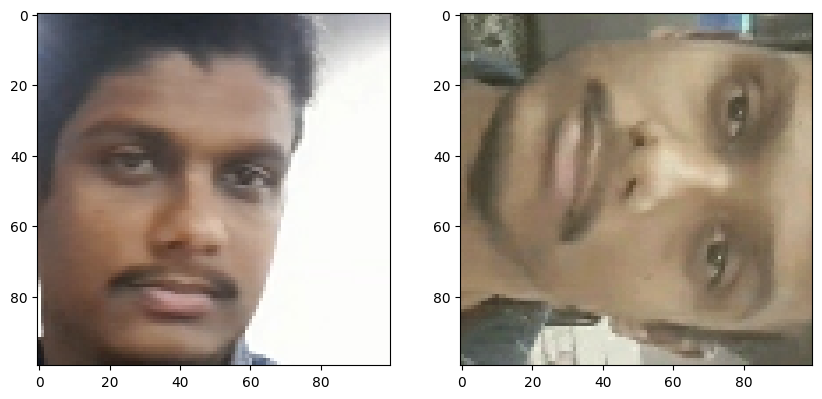

In [83]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

Save Model

In [84]:
# Save weights
siamese_model.save('siamesemodelv2.h5')
L1Dist


c:\Users\MohanaKumariParvatha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


__main__.L1Dist

In [85]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [86]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 246ms/step


array([[1.3967229e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [5.9871663e-10],
       [3.0156369e-05],
       [3.0652661e-11],
       [3.8294975e-11],
       [9.9999982e-01],
       [7.3450343e-11],
       [1.0000000e+00],
       [2.5245008e-05],
       [2.5916270e-06],
       [6.9622241e-10],
       [1.7005326e-04],
       [1.0000000e+00],
       [6.3972939e-06]], dtype=float32)

In [87]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

Real Time Test
 Verification Function

In [89]:
os.listdir(os.path.join('application_data', 'verification_images'))
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [90]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\03dd97fc-e816-11ee-b0de-047c16e5bb51.jpg
application_data\verification_images\04b4fe01-e816-11ee-888a-047c16e5bb51.jpg
application_data\verification_images\1a5f88d3-e819-11ee-bec3-047c16e5bb51 copy.jpg
application_data\verification_images\1a5f88d3-e819-11ee-bec3-047c16e5bb51.jpg
application_data\verification_images\1b00405e-e819-11ee-8a3d-047c16e5bb51.jpg
application_data\verification_images\3fba0c91-e748-11ee-8aaf-743af4ee1197.jpg
application_data\verification_images\3ff7e8f4-e748-11ee-b54f-743af4ee1197.jpg
application_data\verification_images\407a8893-e748-11ee-8b68-743af4ee1197.jpg
application_data\verification_images\409fd2db-e748-11ee-8677-743af4ee1197.jpg
application_data\verification_images\4c9d6982-e815-11ee-9993-047c16e5bb51.jpg
application_data\verification_images\4cc41140-e815-11ee-b1cf-047c16e5bb51.jpg
application_data\verification_images\4dfffd89-e815-11ee-9a90-047c16e5bb51.jpg
application_data\verification_images\4e27f3c0-e815-11ee-89f

In [91]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [92]:
30/50

0.6

OpenCV Real Time Verification

In [93]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.8, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 91ms/step
True
1/1 [==============================] - 0s 91ms/step
True
1/1 [==============================] - 0s 102ms/step
False
1/1 [==============================] - 0s 85ms/step
False


In [94]:
np.sum(np.squeeze(results) > 0.9)

5

In [95]:
results

[array([[1.1336375e-05]], dtype=float32),
 array([[1.0590792e-07]], dtype=float32),
 array([[0.00087135]], dtype=float32),
 array([[0.00087135]], dtype=float32),
 array([[0.00138449]], dtype=float32),
 array([[1.3022972e-07]], dtype=float32),
 array([[1.893962e-07]], dtype=float32),
 array([[3.6744826e-08]], dtype=float32),
 array([[3.197881e-06]], dtype=float32),
 array([[6.992472e-06]], dtype=float32),
 array([[0.00623523]], dtype=float32),
 array([[1.482474e-06]], dtype=float32),
 array([[1.204069e-06]], dtype=float32),
 array([[0.4375173]], dtype=float32),
 array([[4.2903477e-05]], dtype=float32),
 array([[1.2281064e-06]], dtype=float32),
 array([[3.4654279e-06]], dtype=float32),
 array([[0.99832207]], dtype=float32),
 array([[4.6669124e-06]], dtype=float32),
 array([[6.6631537e-06]], dtype=float32),
 array([[1.3204715e-06]], dtype=float32),
 array([[1.6235473e-06]], dtype=float32),
 array([[0.8459349]], dtype=float32),
 array([[0.99476534]], dtype=float32),
 array([[0.99998844]], 